# cifar-classification

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, SubsetRandomSampler
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

Files already downloaded and verified


In [6]:
CFG = {
    "batch_size": 100,
    "lr": 0.001,
    "epochs": 10,
    "input_size": 3072,
    "hidden_features": 128,
    "num_classes": 10,
    "in_channels": 3,
}

In [7]:
random_seed = 42
torch.manual_seed(random_seed);

### First way of Random Sampling

In [8]:
def get_indicies(dataset, percentage=0.2, seed=99):
    np.random.seed(seed)
    indicies = np.random.permutation(len(dataset))
    percentage_length = len(indicies) * percentage
    train_ind = indicies[int(percentage_length):]
    test_ind = indicies[int(-percentage_length):]
    return train_ind, test_ind

In [9]:
train_indicies, test_indicies = get_indicies(dataset)
train_sampler = SubsetRandomSampler(train_indicies) # Picks data for only given indicies
test_sampler = SubsetRandomSampler(test_indicies)

train_dl = DataLoader(dataset, batch_size=CFG["batch_size"], sampler=train_sampler)
test_dl = DataLoader(dataset, batch_size=CFG["batch_size"], sampler=test_sampler)

### Second way of Random Sampling

In [10]:
# train_ds, test_ds = random_split(dataset, [40000, 10000])
# train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True)
# test_dl = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=True)

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

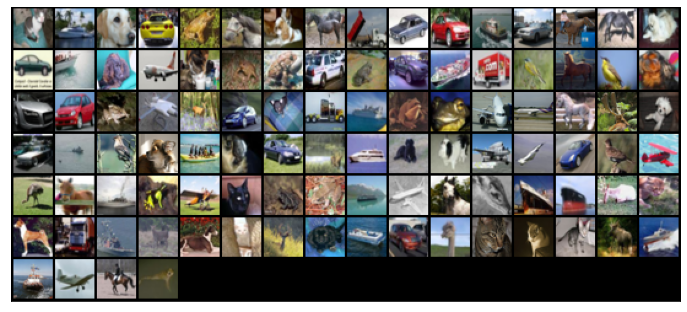

In [12]:
show_batch(train_dl)

In [13]:
for img, lbl in train_dl:
    print(img.shape)
    break

torch.Size([100, 3, 32, 32])


In [14]:
class Net(Module):   
    def __init__(self, in_channels, ):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2), # 256x16x16
            
            # Defining another 2D convolution layer
            Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2), # 128x8x8
            
            # Defining another 2D convolution layer
            Conv2d(128, 64, kernel_size=3, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2), # 64x4x4

            # Defining another 2D convolution layer
            Conv2d(64, 32, kernel_size=3, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2), # 32x2x2

            # Defining another 2D convolution layer
            Conv2d(32, 16, kernel_size=3, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2), # 16x1x1

            nn.Flatten(),
            nn.Linear(16, 10)
        )

        self.linear_layers = Sequential(
            Linear(8 * 2 * 2, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # x = x.view(x.size(0), -1)
        # x = self.linear_layers(x)
        return x

In [15]:
class CIFARMODEL(nn.Module):
    def __init__(self, input_size, hidden_features, num_classes):
        super(CIFARMODEL, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)
        
    def forward(self, xb):
        xb = xb.view(xb.shape[0], -1)
        x = self.fc1(xb)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [16]:
# model = CIFARMODEL(CFG["input_size"], CFG["hidden_features"], CFG["num_classes"])
model = Net(CFG["in_channels"]).to(device)

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=CFG["lr"])

In [ ]:
for i in range(CFG["epochs"]):
    
    model.train()
    for data, label in train_dl:
        data = data.to(device=device)
        label = label.to(device=device)
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"EPOCH: {i+1}: Loss = {loss.item()}")

EPOCH: 1: Loss = 0.9046200513839722
EPOCH: 2: Loss = 0.9510524868965149
EPOCH: 3: Loss = 0.9597923159599304
EPOCH: 4: Loss = 0.7391155362129211
EPOCH: 5: Loss = 0.6230361461639404
EPOCH: 6: Loss = 0.3122042119503021
EPOCH: 7: Loss = 0.4755672514438629
EPOCH: 8: Loss = 0.5330202579498291
EPOCH: 9: Loss = 0.2626143991947174


In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_dl, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_dl, model)*100:.2f}")

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="cifar-classification")